# Replication of attack on VoIP end-to-end encrypted messengers

## Loading dataset

First we will try to load our data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set()  # make plots nicer

np.random.seed(42)  # set seed for reproducibility

Format of the input file is as follows (with examples of data, that can be there):  
**Line indicating spoken phrase:** _Sentence: "She had your dark suit in greasy wash water all year."_  
**Line with information about current transmission** _Packets: 146, Samples: 46797, Samples per packet: 320_  
**Line with data**: _74;ix,hv;"she","had"_ (packet size, phonemes, words)

In [2]:
# data format: name (of csv file); sentence; (packet size, [phonems], [words])
def file_parser(path):
    file = open(path, 'r')
    lines = file.readlines()
    
    file_name = [path.split('/')[-1]]
    sentence = ""
    file_data = []
    
    for line in lines:
        line = line.strip()
        
        # if there are only 2 informations on line and second is h#, then ignore
        # strip line, split primarly on ; secondary on ,
        if (line.startswith('#')):
            if (not sentence):
                sentence = line[len('# Sentence: "'): len(line) - 1]
            continue
        
        line = line.split(';')
        
        if (len(line) == 1):
            #lines containing only their packet size and nothing else, they should be added
            line += [""]
            line += [""]
        
        if (len(line) == 2):
            #this tries to remove most of the silence at the start of the recording
            #if (line[1] == 'h#'):
            #    continue
            line += [""]
        
        line[1] = tuple(line[1].split(','))
        line[2] = tuple(list(map(lambda a: a.strip('"'), line[2].split(','))))
           
        # file_name and author contain duplicate informations, but are kept for readability
        line = file_name + [file_name[0][0:9]] + [sentence] + line
        file_data += [line]

    return pd.DataFrame(file_data, columns=['file', 'speaker', 'sentence', 'packet_size', 'phonemes', 'words'])

def load_files(directory):
    filelist = os.listdir(directory)
    #read them into pandas
    df_list = [file_parser(directory+file) for file in filelist]
    #concatenate them together
    return pd.concat(df_list, ignore_index=True)

In [3]:
#file_parser("./../data/skype_train_data/DR1-FSAH0-SI614.CSV")   

data = load_files("./../data/skype_train_data/")
data

,file,speaker,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,"(h#,)","(,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,31,"(h#,)","(,)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,"(h#,)","(,)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,"(h#,)","(,)"
...,...,...,...,...,...,...
707433,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,32,"(h#,)","(,)"
707434,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,34,"(h#,)","(,)"
707435,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,39,"(h#,)","(,)"
707436,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,33,"(h#,)","(,)"


For our purposes we've decided to omit beggings and ends of the files as they contain only some silence. Maybe it would be worth investigating what the accuracy would be, had we not remowed these.

Let's convert the `packet_size` from _object_ to _numerical value_ and `file`, `sentence` to the type _category_.

In [4]:
data['packet_size'] = pd.to_numeric(data['packet_size'])

In [5]:
data['file'] = data['file'].astype('category')
data['sentence'] = data['sentence'].astype('category')
#data['speaker'] = data['speaker'].astype('category')

In [6]:
data.dtypes

file           category
speaker          object
sentence       category
packet_size       int64
phonemes         object
words            object
dtype: object

Making the dataset contain only data points with one phoneme label

In [7]:
data = data.loc[data.phonemes.apply(len) == 1].reset_index(drop=True)
data

,file,speaker,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,"(h#,)","(,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,31,"(h#,)","(,)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,"(h#,)","(,)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,"(h#,)","(,)"
...,...,...,...,...,...,...
533700,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,32,"(h#,)","(,)"
533701,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,34,"(h#,)","(,)"
533702,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,39,"(h#,)","(,)"
533703,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,33,"(h#,)","(,)"


In [8]:
len(data.phonemes)

533705

In [9]:
pd.unique(data.phonemes)

array([('h#',), ('sh',), ('ix',), ('hv',), ('eh',), ('jh',), ('ih',),
       ('dcl',), ('ah',), ('kcl',), ('k',), ('s',), ('ux',), ('q',),
       ('en',), ('r',), ('w',), ('ao',), ('axr',), ('l',), ('y',),
       ('uh',), ('n',), ('ae',), ('dx',), ('oy',), ('ax',), ('gcl',),
       ('dh',), ('tcl',), ('iy',), ('v',), ('t',), ('f',), ('ow',),
       ('d',), ('hh',), ('ch',), ('bcl',), ('aa',), ('em',), ('ng',),
       ('m',), ('ay',), ('th',), ('ax-h',), ('ey',), ('p',), ('pcl',),
       ('aw',), ('er',), ('z',), ('epi',), ('el',), ('uw',), ('g',),
       ('',), ('b',), ('pau',), ('zh',), ('nx',), ('eng',)], dtype=object)

Taken from: https://github.com/jhasegaw/phonecodes/blob/master/src/phonecode_tables.py

In [10]:
arpa_to_ipa = {
    'aa':'ɑ',
    'ae':'æ',
    'ah':'ʌ',
    'ah0':'ə',
    'ao':'ɔ',
    'aw':'aʊ',
    'ay':'aɪ',
    'eh':'ɛ',
    'er':'ɝ',
    'er0':'ɚ',
    'ey':'eɪ',
    'ih':'ɪ',
    'ih0':'ɨ',
    'iy':'i',
    'ow':'oʊ',
    'oy':'ɔɪ',
    'uh':'ʊ',
    'uw':'u',
    'b':'b',
    'ch':'tʃ',
    'd':'d',
    'dh':'ð',
    'el':'l̩',
    'em':'m̩',
    'en':'n̩',
    'f':'f',
    'g':'ɡ',
    'hh':'h',
    'jh':'dʒ',
    'k':'k',
    'l':'l',
    'm':'m',
    'n':'n',
    'ng':'ŋ',
    'p':'p',
    'q':'ʔ',
    'r':'ɹ',
    's':'s',
    'sh':'ʃ',
    't':'t',
    'th':'θ',
    'v':'v',
    'w':'w',
    'wh':'ʍ',
    'y':'j',
    'z':'z',
    'zh':'ʒ',

    'ax':'ə',
    'ax-h':'ə̥',
    'axr':'ɚ',
    'bcl':'b',
    'dcl':'d',
    'dx':'ɾ',
    'eng':'ŋ̍',
    'epi':'',
    'gcl':'g',
    'hv':'ɦ',
    'h#':'',
    'ix':'ɨ',
    'kcl':'k',
    'nx':'ɾ̃',
    'pau':'',
    'pcl':'p',
    'tcl':'t',
    'ux':'ʉ',
    '':'',
}

In [11]:
len(arpa_to_ipa)

66

This modification is based on this: https://en.wikipedia.org/wiki/ARPABET (+ minor guessing)

In [12]:
ipa_allophone = {
    'ŋ̍':'n', #should be ŋ
    'ə̥':'ɛ',
    'ɨ':'ɪ',
    'n̩':'n',
    'm̩':'m',
    'ŋ':'n',
    'ɾ̃':'n',
    'ð':'θ',
    'ʉ':'u',
    'ɾ':'d',
    'l̩':'l',
}

In [13]:
uniq_phon = pd.unique(data.phonemes)
for i in range(len(uniq_phon)):
    uniq_phon[i] = arpa_to_ipa.get(uniq_phon[i][0], uniq_phon[i][0])
    uniq_phon[i] = ipa_allophone.get(uniq_phon[i], uniq_phon[i])
    
uniq_phon

array(['', 'ʃ', 'ɪ', 'ɦ', 'ɛ', 'dʒ', 'ɪ', 'd', 'ʌ', 'k', 'k', 's', 'u',
       'ʔ', 'n', 'ɹ', 'w', 'ɔ', 'ɚ', 'l', 'j', 'ʊ', 'n', 'æ', 'd', 'ɔɪ',
       'ə', 'g', 'θ', 't', 'i', 'v', 't', 'f', 'oʊ', 'd', 'h', 'tʃ', 'b',
       'ɑ', 'm', 'n', 'm', 'aɪ', 'θ', 'ɛ', 'eɪ', 'p', 'p', 'aʊ', 'ɝ', 'z',
       '', 'l', 'u', 'ɡ', '', 'b', '', 'ʒ', 'n', 'n'], dtype=object)

In [14]:
len(np.unique(uniq_phon))

43

Now modifying our input dataset:

In [15]:
#input is expected to be a tuple
def convert_phoneme(phoneme):
    tmp_1 = arpa_to_ipa.get(phoneme[0], phoneme[0])
    tmp_2 = ipa_allophone.get(tmp_1, tmp_1)
    return tmp_2

In [16]:
data['phonemes'] = data["phonemes"].apply(convert_phoneme)
data

,file,speaker,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,,"(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,,"(,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,31,,"(,)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,,"(,)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,,"(,)"
...,...,...,...,...,...,...
533700,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,32,,"(,)"
533701,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,34,,"(,)"
533702,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,39,,"(,)"
533703,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,33,,"(,)"


## Exploratory analysis

For most of our exploratory analysis we will use the powerfull tool of `pandas_profilling` which can provide us with many interesting graphs and statistics, which we can use.

Our first step in exploratory analysis will be to just to look at data without modifying anything (expect the column types)

In [17]:
import pandas_profiling as pp
from pandas_profiling import ProfileReport

ProfileReport(data, "First look at data")

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From this analysis we can see, that we have 4620 distinct files (which isn't surprising, we already knew that), 462 distinct speakers and 1737 unique sentences. Sadly `pandas_profilling` doesn't seem to be up to this task as converting phonemes and words to cathegorical values breaks `pandas_profilling`. This is caused by current implementation of `pandas` that requires categorical list like objects to be of the same length so it can do the comparison (_categorical.py in func(self, other), lines 70 to 72_).

Now we will get the frequencies of senteces.

In [18]:
frequencies = data[['sentence', 'file']].drop_duplicates(subset=['file'])['sentence'].value_counts()
frequencies

She had your dark suit in greasy wash water all year.                         462
Don't ask me to carry an oily rag like that.                                  461
Growing well-kept gardens is very time consuming.                               7
Correct execution of my instructions is crucial.                                7
Cyclical programs will never compile.                                           7
                                                                             ... 
Sprouted grains and seeds are used in salads and dishes such as chop suey.      1
State numbering laws differ from each other in many ways.                       1
Stay right here where you are, kid, he called.                                  1
Stoneware clay for tiles.                                                       1
"Cable confirmation", it said translated.                                       1
Name: sentence, Length: 1737, dtype: int64

In [19]:
np.asarray(np.unique(frequencies.array.to_numpy(), return_counts=True)).T

array([[   1, 1402],
       [   2,    3],
       [   4,    1],
       [   5,    2],
       [   6,   14],
       [   7,  313],
       [ 461,    1],
       [ 462,    1]])

We can see, that the sentence column is heavily skewed as 30% of our dataset is composed of sentences, which are spoken only once. 10% takes the sentence _She had your dark suit in greasy wash water all year._ and another 10% takes sentence _Don't ask me to carry an oily rag like that._ The remaining 50% of the data are sentences, that have more than one occurance, but not by a high margin.

Now we can properly convert words and phonemes to their proper type -> category

In [20]:
# this conversion breaks pandas_profiling :(
# actually I know why this breaks profilling, pandas requieres categorical list like structures to be of the same length for reasons unknown
data['phonemes'] = data['phonemes'].astype('category')
data['words'] = data['words'].astype('category')

### Statistic for packet sizes for specific phonemes / words

Now let's look at packet sizes for few select words / phonemes. From the first look at data I would say, that packet sizes for phonemes will be more important for the `skype` dataset and packet sizes for words will be more important for `whatsapp` dataset.<br />
This is because `skype` dataset uses much smaller packet sizes, therefore it is highly probable, that only one phoneme will correspond to only one packet size and the same goes for `whatsapp` dataset, that has much bigger packets and from my observation one packet corresponds to one word.

In [21]:
label_data = data.loc[:, ('packet_size', 'phonemes', 'words', 'sentence')]
label_data

,packet_size,phonemes,words,sentence
0,32,,"(,)",She had your dark suit in greasy wash water al...
1,32,,"(,)",She had your dark suit in greasy wash water al...
2,31,,"(,)",She had your dark suit in greasy wash water al...
3,28,,"(,)",She had your dark suit in greasy wash water al...
4,28,,"(,)",She had your dark suit in greasy wash water al...
...,...,...,...,...
533700,32,,"(,)",Good service should be rewarded by big tips.
533701,34,,"(,)",Good service should be rewarded by big tips.
533702,39,,"(,)",Good service should be rewarded by big tips.
533703,33,,"(,)",Good service should be rewarded by big tips.


In [22]:
len(pd.unique(label_data['phonemes']))

43

In [23]:
len(pd.unique(label_data['words']))

5104

From this we can see, that we have 3083 unique n-grams of phonemes and 15713 unique n-grams of words.

#### Phonemes

Now we will look at the top most occuring phonemes and define analysis for specific phonemes / words:

In [24]:
label_frequencies = label_data['phonemes'].value_counts()
label_frequencies.head(20)

      93244
s     34535
ɪ     28247
æ     25557
i     24409
k     19244
t     17570
n     17388
ɑ     15627
ɔ     15233
l     14888
aɪ    14780
ɛ     13910
ɹ     13192
eɪ    12160
z     11908
oʊ    11284
u     10740
ʃ     10634
ɚ     10402
Name: phonemes, dtype: int64

In [25]:
from IPython.display import display

def get_distribution_info(dataframe, xlabel):
    Q1 = dataframe.packet_size.quantile(0.25)
    Q3 = dataframe.packet_size.quantile(0.75)
    IQR = Q3 - Q1

    print("Current label:\t\t", xlabel)
    print("Total values:", dataframe.packet_size.count())
    print("Lower outsiders:", (dataframe.packet_size < (Q1 - 1.5 * IQR)).sum())
    print("Upper outsiders:", (dataframe.packet_size > (Q3 + 1.5 * IQR)).sum())
    print()
    
    plt.figure()
    dataframe.packet_size.plot.box()
    plt.xlabel(xlabel)
    plt.show()
    plt.figure()
    dataframe.packet_size.plot.hist()
    plt.show()

    #display(dataframe[dataframe.packet_size < (Q1 - 1.5 * IQR)].sort_values('packet_size').head(10))
    #display(dataframe[dataframe.packet_size > (Q3 + 1.5 * IQR)].sort_values('packet_size', ascending=False).head(10))
    
    display(dataframe.sort_values('packet_size').head(10))
    display(dataframe.sort_values('packet_size', ascending=False).head(10))

We will take a look at a few of the most common phonemes (and the most common pair of phonemes) and see whether they are evenly distributed or not at all:

Unique packet values: 59 	Unique words: 1721
Current label:		 s
Total values: 34535
Lower outsiders: 170
Upper outsiders: 702



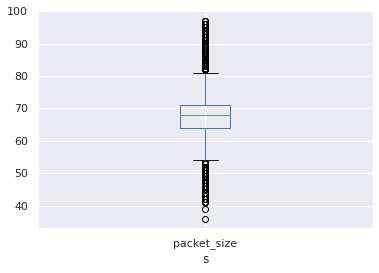

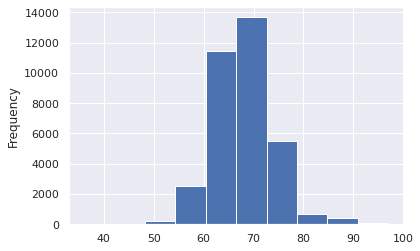

,packet_size,phonemes,words,sentence
484749,36,s,"(audience,)","As coauthors, we presented our new book to the..."
195763,39,s,"(square,)",While waiting for Chipper she crisscrossed the...
269979,41,s,"(miraculous,)",The new birth is miraculous and mysterious.
474172,41,s,"(unions,)",It was most effective against trade unions.
10149,41,s,"(coexist,)",Curiosity and mediocrity seldom coexist.
276921,41,s,"(exquisite,)",Vietnamese cuisine is exquisite.
26190,42,s,"(regulations,)",Etiquette mandates compliance with existing re...
60421,42,s,"(offensive,)",Nothing is as offensive as innocence.
71291,42,s,"(coincided,)",Employee layoffs coincided with the company's ...
209906,42,s,"(ask,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
113066,97,s,"(zoologist,)",The easygoing zoologist relaxed throughout the...
285868,97,s,"(progress,)",Scientific progress comes from the development...
62219,97,s,"(strip,)",A smile pulled at the lower strip of adhesive ...
106225,96,s,"(exist,)","Mosquitoes exist in warm, humid climates."
531620,96,s,"(fibrosis,)","Microscopically, there was emphysema, fibrosis..."
276604,96,s,"(snarled,)",She snarled warningly.
413437,96,s,"(ambidextrous,)",Ambidextrous pickpockets accomplish more.
72104,96,s,"(lists,)",The data are presented in lists and tables.
151543,95,s,"(mathews,)","Davy Mathews! It's disgusting, the way you're ..."
508940,95,s,"(greasy,)",She had your dark suit in greasy wash water al...




Unique packet values: 68 	Unique words: 634
Current label:		 æ
Total values: 25557
Lower outsiders: 96
Upper outsiders: 31



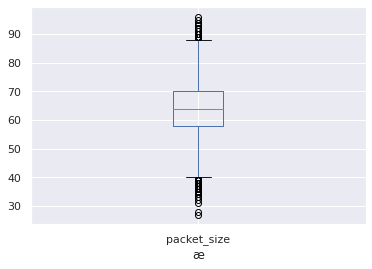

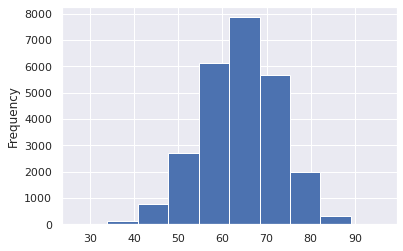

,packet_size,phonemes,words,sentence
17230,27,æ,"(that,)",Don't ask me to carry an oily rag like that.
298086,28,æ,"(that,)",Don't ask me to carry an oily rag like that.
255081,31,æ,"(that,)",Don't ask me to carry an oily rag like that.
307967,32,æ,"(rag,)",Don't ask me to carry an oily rag like that.
270943,33,æ,"(that,)",Don't ask me to carry an oily rag like that.
450323,33,æ,"(that,)",Don't ask me to carry an oily rag like that.
295536,34,æ,"(mask,)",The prowler wore a ski mask for disguise.
416300,34,æ,"(man,)",For a man of his mass he was curiously short.
223819,34,æ,"(hand,)",Publicity and notoriety go hand in hand.
320846,35,æ,"(rag,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
258273,96,æ,"(ask,)",Don't ask me to carry an oily rag like that.
357028,95,æ,"(ask,)",Don't ask me to carry an oily rag like that.
419472,94,æ,"(lack,)",The lack of heat compounded the tenant's griev...
144347,94,æ,"(wagons,)",The wagons were burning fiercely.
301714,93,æ,"(trespassing,)",Trespassing is forbidden and subject to penalty.
362503,93,æ,"(laboratory,)",Thirty-five military and civilian students rec...
281197,92,æ,"(ask,)",Don't ask me to carry an oily rag like that.
94936,92,æ,"(nevada,)",Brush fires are common in the dry underbrush o...
489634,92,æ,"(that,)",Don't ask me to carry an oily rag like that.
176249,91,æ,"(rag,)",Don't ask me to carry an oily rag like that.




Unique packet values: 66 	Unique words: 2238
Current label:		 ɪ
Total values: 28247
Lower outsiders: 180
Upper outsiders: 40



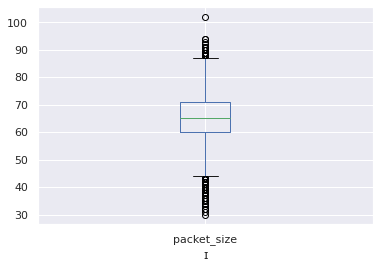

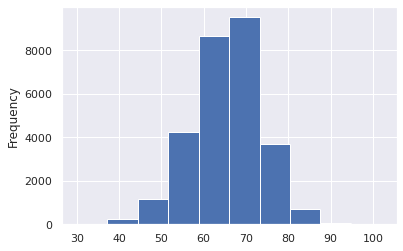

,packet_size,phonemes,words,sentence
404822,30,ɪ,"(clothing,)","In the long run, it pays to buy quality clothing."
466632,31,ɪ,"(ices,)",The paper boy bought two apples and three ices.
291691,32,ɪ,"(delicious,)",Cottage cheese with chives is delicious.
404823,32,ɪ,"(clothing,)","In the long run, it pays to buy quality clothing."
416841,32,ɪ,"(in,)","The moisture in my eyes is from eyedrops, not ..."
260127,33,ɪ,"(at,)",Bob found more clams at the ocean's edge.
14108,34,ɪ,"(carry,)",Don't ask me to carry an oily rag like that.
269465,34,ɪ,"(is,)","It is a happy, buzzing crowd."
235339,34,ɪ,"(curiosity,)",Avowed atheists or freethinkers are so rare as...
466634,34,ɪ,"(ices,)",The paper boy bought two apples and three ices.


,packet_size,phonemes,words,sentence
125938,102,ɪ,"(year,)",She had your dark suit in greasy wash water al...
17431,94,ɪ,"(program,)",Program note reads as follows: take hands; thi...
136506,94,ɪ,"(development,)",Scientific progress comes from the development...
531775,93,ɪ,"(bit,)","Oh, you'll wobble and weave quite a bit at first."
67464,92,ɪ,"(with,)",Ralph prepared red snapper with fresh lemon sa...
83916,91,ɪ,"(retirement,)",Hiring the wife for one's company may win her...
84042,91,ɪ,"(hurriedly,)",New self-deceiving rags are hurriedly tossed o...
109941,91,ɪ,"(with,)",Approach your interview with statuesque compos...
250931,90,ɪ,"(modeling,)",We apply auditory modeling to computer speech ...
460569,90,ɪ,"(the,)",The world is constantly changing; what was new...




Unique packet values: 68 	Unique words: 137
Current label:		 
Total values: 93244
Lower outsiders: 0
Upper outsiders: 2137



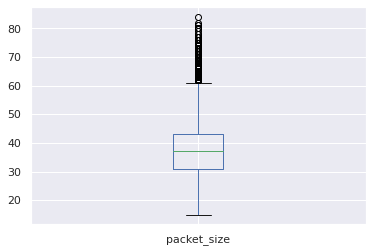

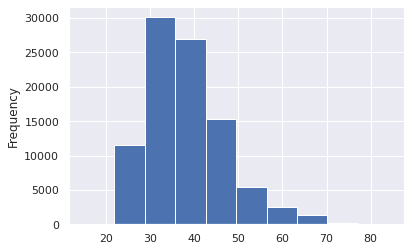

,packet_size,phonemes,words,sentence
513833,15,,"(,)",You always come up with pathological examples.
155034,17,,"(,)",Don't ask me to carry an oily rag like that.
78620,18,,"(,)",Don't ask me to carry an oily rag like that.
402451,19,,"(,)",The rose corsage smelled sweet.
416735,19,,"(,)","Draw every outer line first, then fill in the ..."
143340,19,,"(,)",The Mayan neoclassic scholar disappeared while...
29858,19,,"(,)",We will achieve a more vivid sense of what it ...
361685,20,,"(,)",Count the number of teaspoons of soysauce that...
276935,20,,"(,)",Vietnamese cuisine is exquisite.
517434,20,,"(,)",Suburban housewives often suffer from the gab ...


,packet_size,phonemes,words,sentence
101027,84,,"(,)",Westchester is a county in New York.
439856,82,,"(,)",Trespassing is forbidden and subject to penalty.
22884,81,,"(,)","But briefly, the topping configuration must be..."
28520,81,,"(,)",The eastern coast is a place for pure pleasure...
135985,80,,"(,)",She had your dark suit in greasy wash water al...
357615,80,,"(,)",You had to be stupid or crazy or immortal.
381277,80,,"(,)","The filtered air benefits allergies, asthma, s..."
83415,79,,"(,)",The Thinker is a famous sculpture.
439647,78,,"(,)",Every single problem touched on thus far is re...
98615,78,,"(,)",Fall slowly forward onto the hands and let the...


In [26]:
label_data['phonemes'] = label_data['phonemes'].astype('object')

#change this array for analysis on more values
interesting_phonemes = [("s"), ("æ"), ("ɪ"), ("")]

for phoneme in interesting_phonemes:
    graph_data = label_data.loc[label_data.phonemes == phoneme]
    print("Unique packet values:", len(pd.unique(graph_data['packet_size'])), "\tUnique words:", len(pd.unique(graph_data['words'])))
    get_distribution_info(graph_data, phoneme)
    print('\n')

label_data['phonemes'] = label_data['phonemes'].astype('category')

From these graphs we can already see a few alarming things. First of all the phonemes sizes are all over the place suggesting, that there shouldn't be much a a correlation between packet size and spoken phonemes. We will try to make further observations taking into account the surrounding phonemes as that should prove more fruitfull than only focusing on phonemes alone.

#### Words

In [27]:
label_frequencies = label_data['words'].value_counts()
label_frequencies.head(20)

(,)          95685
(that,)       7442
(wash,)       6766
(suit,)       6564
(greasy,)     6230
(rag,)        6211
(oily,)       6159
(carry,)      6042
(year,)       5822
(dark,)       5178
(ask,)        5122
(water,)      4819
(she,)        4459
(all,)        4443
(like,)       4325
(had,)        4259
(in,)         4097
(the,)        3388
(don't,)      2982
(to,)         2949
Name: words, dtype: int64

Unique values: 73 	Unique phonemes: 9
Current label:		 ('',)
Total values: 95685
Lower outsiders: 0
Upper outsiders: 3050



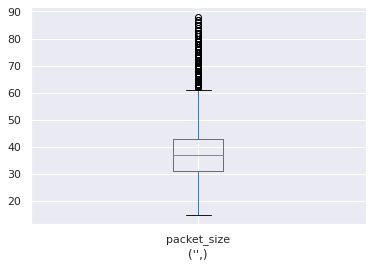

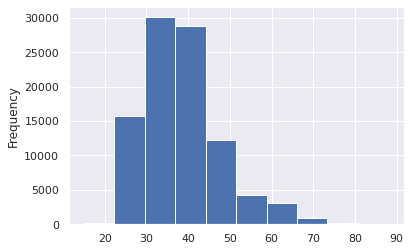

,packet_size,phonemes,words,sentence
513833,15,,"(,)",You always come up with pathological examples.
155034,17,,"(,)",Don't ask me to carry an oily rag like that.
78620,18,,"(,)",Don't ask me to carry an oily rag like that.
143340,19,,"(,)",The Mayan neoclassic scholar disappeared while...
416735,19,,"(,)","Draw every outer line first, then fill in the ..."
402451,19,,"(,)",The rose corsage smelled sweet.
29858,19,,"(,)",We will achieve a more vivid sense of what it ...
8505,20,,"(,)","As these maladies overlap, so must the cure."
210506,20,,"(,)",The bluejay flew over the high building.
361685,20,,"(,)",Count the number of teaspoons of soysauce that...


,packet_size,phonemes,words,sentence
66592,88,ʔ,"(,)",She had your dark suit in greasy wash water al...
362962,87,ʔ,"(,)",They often go out in the evening.
71810,87,ʔ,"(,)",She had your dark suit in greasy wash water al...
248417,86,ʔ,"(,)",Correct execution of my instructions is crucial.
380753,85,ʔ,"(,)",She had your dark suit in greasy wash water al...
173765,85,ʔ,"(,)",Women may never become completely equal to men.
208726,85,ʔ,"(,)",She had your dark suit in greasy wash water al...
329895,85,ʔ,"(,)","Draw every outer line first, then fill in the ..."
101027,84,,"(,)",Westchester is a county in New York.
311724,83,ʔ,"(,)",She had your dark suit in greasy wash water al...




Unique values: 73 	Unique phonemes: 13
Current label:		 ('that',)
Total values: 7442
Lower outsiders: 0
Upper outsiders: 0



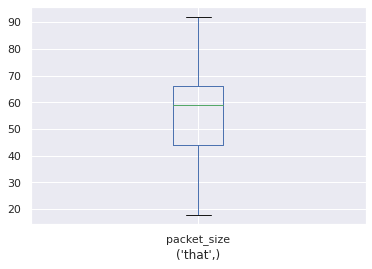

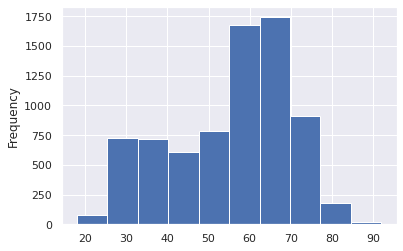

,packet_size,phonemes,words,sentence
447732,18,θ,"(that,)",The proof that you are seeking is not availabl...
380293,20,t,"(that,)",Count the number of teaspoons of soysauce that...
528138,21,t,"(that,)",Don't ask me to carry an oily rag like that.
221273,21,t,"(that,)",Don't ask me to carry an oily rag like that.
442354,22,t,"(that,)",The full moon shone brightly that night.
52674,22,θ,"(that,)",Don't ask me to carry an oily rag like that.
205232,22,θ,"(that,)",Don't ask me to carry an oily rag like that.
78116,22,t,"(that,)",That dog chases cats mercilessly.
440572,22,t,"(that,)",Don't ask me to carry an oily rag like that.
63101,23,θ,"(that,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
489634,92,æ,"(that,)",Don't ask me to carry an oily rag like that.
137272,90,æ,"(that,)",You could also say that in these pamphlets is ...
256144,89,æ,"(that,)",Don't ask me to carry an oily rag like that.
22659,88,æ,"(that,)",Don't ask me to carry an oily rag like that.
115099,88,æ,"(that,)",Don't ask me to carry an oily rag like that.
33783,87,æ,"(that,)",I'll have a scoop of that exotic purple and tu...
218877,87,æ,"(that,)",Don't ask me to carry an oily rag like that.
251611,87,æ,"(that,)",Don't ask me to carry an oily rag like that.
514507,86,æ,"(that,)",Don't ask me to carry an oily rag like that.
463082,86,θ,"(that,)",They all agree that the essay is barely intell...




Unique values: 71 	Unique phonemes: 10
Current label:		 ('greasy',)
Total values: 6230
Lower outsiders: 336
Upper outsiders: 63



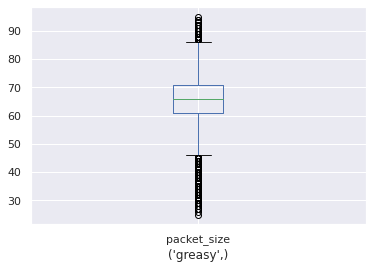

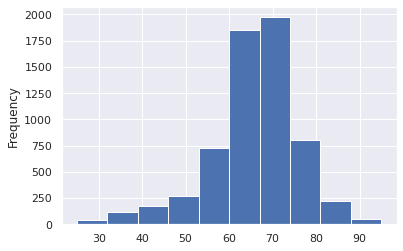

,packet_size,phonemes,words,sentence
428226,25,g,"(greasy,)",She had your dark suit in greasy wash water al...
249067,26,g,"(greasy,)",She had your dark suit in greasy wash water al...
39189,27,g,"(greasy,)",She had your dark suit in greasy wash water al...
40197,27,g,"(greasy,)",She had your dark suit in greasy wash water al...
299425,27,g,"(greasy,)",She had your dark suit in greasy wash water al...
328021,27,g,"(greasy,)",She had your dark suit in greasy wash water al...
106794,27,g,"(greasy,)",She had your dark suit in greasy wash water al...
173974,28,g,"(greasy,)",She had your dark suit in greasy wash water al...
328020,28,g,"(greasy,)",She had your dark suit in greasy wash water al...
433376,28,g,"(greasy,)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
508940,95,s,"(greasy,)",She had your dark suit in greasy wash water al...
210842,94,z,"(greasy,)",She had your dark suit in greasy wash water al...
211904,94,s,"(greasy,)",She had your dark suit in greasy wash water al...
276444,93,z,"(greasy,)",She had your dark suit in greasy wash water al...
173981,93,s,"(greasy,)",She had your dark suit in greasy wash water al...
274381,92,z,"(greasy,)",She had your dark suit in greasy wash water al...
28699,92,s,"(greasy,)",She had your dark suit in greasy wash water al...
163142,92,s,"(greasy,)",She had your dark suit in greasy wash water al...
219778,92,s,"(greasy,)",She had your dark suit in greasy wash water al...
135929,92,s,"(greasy,)",She had your dark suit in greasy wash water al...




Unique values: 56 	Unique phonemes: 10
Current label:		 ('year',)
Total values: 5822
Lower outsiders: 45
Upper outsiders: 22



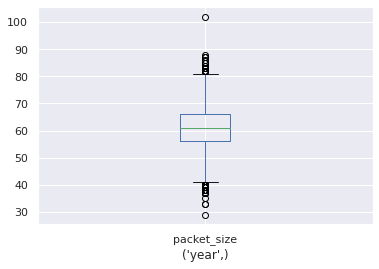

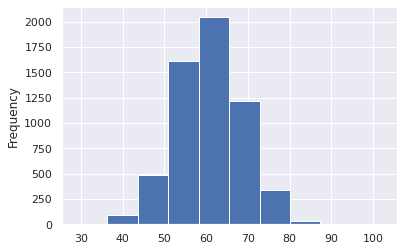

,packet_size,phonemes,words,sentence
413618,29,j,"(year,)",She had your dark suit in greasy wash water al...
60695,33,j,"(year,)",She had your dark suit in greasy wash water al...
218791,33,j,"(year,)",She had your dark suit in greasy wash water al...
127050,35,ɚ,"(year,)",She had your dark suit in greasy wash water al...
484066,37,j,"(year,)",She had your dark suit in greasy wash water al...
3201,37,ɪ,"(year,)",She had your dark suit in greasy wash water al...
374874,37,ɝ,"(year,)",She had your dark suit in greasy wash water al...
28726,37,j,"(year,)",She had your dark suit in greasy wash water al...
497268,38,j,"(year,)",She had your dark suit in greasy wash water al...
36807,38,j,"(year,)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
125938,102,ɪ,"(year,)",She had your dark suit in greasy wash water al...
439070,88,h,"(year,)",She had your dark suit in greasy wash water al...
525002,87,j,"(year,)",She had your dark suit in greasy wash water al...
498657,87,ɝ,"(year,)",She had your dark suit in greasy wash water al...
122404,87,ɝ,"(year,)",She had your dark suit in greasy wash water al...
397938,86,ɚ,"(year,)",She had your dark suit in greasy wash water al...
463674,85,ɚ,"(year,)",She had your dark suit in greasy wash water al...
2176,85,j,"(year,)",She had your dark suit in greasy wash water al...
390209,84,j,"(year,)",She had your dark suit in greasy wash water al...
32832,84,ɪ,"(year,)",She had your dark suit in greasy wash water al...


In [28]:
label_data['words'] = label_data['words'].astype('object')

#change this array for analysis on more values
interesting_words = [("",), ("that",), ("greasy",), ("year",)]

for word in interesting_words:
    graph_data = label_data.loc[label_data.words == word]
    #graph_data = graph_data.copy() #.loc was somehow acting up and not copying properly
    print("Unique values:", len(pd.unique(graph_data['packet_size'])), "\tUnique phonemes:", len(pd.unique(graph_data['phonemes'])))
    get_distribution_info(graph_data, word)
    print('\n')

label_data['phonemes'] = label_data['phonemes'].astype('category')

We can see, that the distribution is still all over the place, but more concise than for phonemes, which is kinda surprising. But the problem here is that for longer words we have multiple packets that corespond to said word.

### Feature engineering

Our current analysises so far have only taken into account packet_size alone. Now we will foccus on surrounding packet sizes so we can deduce much more information about our packet sizes and their correspondence to phonemes / words.  
So let's look at data once again:

In [29]:
data

,file,speaker,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,,"(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,,"(,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,31,,"(,)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,,"(,)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,,"(,)"
...,...,...,...,...,...,...
533700,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,32,,"(,)"
533701,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,34,,"(,)"
533702,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,39,,"(,)"
533703,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,33,,"(,)"


We will modify our file parsing function to add previous and next packet size to each record.

In [30]:
def file_parser_with_prev_next(path):
    file = open(path, 'r')
    lines = file.readlines()
    
    file_name = [path.split('/')[-1]]
    sentence = ""
    file_data = []
    
    has_value = False
    previous = 0
    
    for line in lines:
        line = line.strip()
        
        # if there are only 2 informations on line and second is h#, then ignore
        # strip line, split primarly on ; secondary on ,
        if (line.startswith('#')):
            if (not sentence):
                sentence = line[len('# Sentence: "'): len(line) - 1]
            continue
        
        line = line.split(';')
        
        if (len(line) == 1):
            #lines containing only their packet size and nothing else, they should be added
            #TODO
            line += [""]
            line += [""]
            #continue
        
        if (len(line) == 2):
            #this tries to remove most of the silence at the start of the recording
            #potentionally harmfull as we shouldn't clean test data this way (we will be reading labels)
            #if (line[1] == 'h#'):
            #    continue
            line += [""]
        
        line[1] = tuple(line[1].split(','))
        line[2] = tuple(list(map(lambda a: a.strip('"'), line[2].split(','))))
        
        if (has_value):
            file_data[-1][-4] = line[0]
           
        # file_type and sentence contain duplicate informations, but are kept for readability
        split_filename = file_name[0].split('-')
        
        line = file_name + [split_filename[0]] + [split_filename[1]] + [split_filename[2][0:-4]] + [sentence] + [previous] + [0] + line
        #adding previous as feature
        previous = line[-3]
        file_data += [line]
        
        #adding next frame as feature
        has_value = True
        
    return pd.DataFrame(file_data, columns=['file', 'dialect', 'speaker', 'sentence_id', 'sentence', 'previous_packet', 'next_packet','packet_size', 'phonemes', 'words'])

def load_files_with_prev_next(directory):
    filelist = os.listdir(directory)
    #read them into pandas
    df_list = [file_parser_with_prev_next(directory+file) for file in filelist]
    #concatenate them together
    return pd.concat(df_list, ignore_index=True)

def convert_types(data_frame):
    data_frame['packet_size'] = pd.to_numeric(data_frame['packet_size'])
    data_frame['previous_packet'] = pd.to_numeric(data_frame['previous_packet'])
    data_frame['next_packet'] = pd.to_numeric(data_frame['next_packet'])

    data_frame['file'] = data_frame['file'].astype('category')
    data_frame['sentence'] = data_frame['sentence'].astype('category')
    
    data_frame['dialect'] = data_frame['dialect'].astype('category')
    data_frame['speaker'] = data_frame['speaker'].astype('category')
    data_frame['sentence_id'] = data_frame['sentence_id'].astype('category')

First we will be trying to explore Skype data set as the aproach, that we will be trying first requires smaller packet sizes (we need to be able to distinguish the word boundaries for our feature columns).

Now we will try to comeup with with new features for our dataset.

The new features we will be considering for our dataset are:
- previous packet_size
- next packet_size
- bigram of previous and current
- bigram of next and current
- trigram of previous and current

In [31]:
skype_data = load_files_with_prev_next("./../data/skype_train_data/")
convert_types(skype_data)
skype_data

,file,dialect,speaker,sentence_id,sentence,previous_packet,next_packet,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,0,32,32,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,32,31,32,"(h#,)","(,)"
2,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,32,28,31,"(h#,)","(,)"
3,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,31,28,28,"(h#,)","(,)"
4,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,28,36,28,"(h#,)","(,)"
...,...,...,...,...,...,...,...,...,...,...
707433,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,47,34,32,"(h#,)","(,)"
707434,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,32,39,34,"(h#,)","(,)"
707435,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,34,33,39,"(h#,)","(,)"
707436,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,39,36,33,"(h#,)","(,)"


We will also be considering bigrams of current and previous / next and trigram of (previous, current, next) packet sizes.

In [32]:
def add_surrounding(data_frame):
    data_frame['prev_curr'] = list(zip(data_frame.previous_packet, data_frame.packet_size))
    data_frame['next_curr'] = list(zip(data_frame.next_packet, data_frame.packet_size))
    data_frame['packet_surrounding'] = list(zip(data_frame.previous_packet, data_frame.packet_size, data_frame.next_packet))
    
    #data_frame['prev_curr'] = data_frame['prev_curr'].astype('category')
    #data_frame['next_curr'] = data_frame['next_curr'].astype('category')
    #data_frame['packet_surrounding'] = data_frame['packet_surrounding'].astype('category')

add_surrounding(skype_data)
skype_data.dtypes

file                  category
dialect               category
speaker               category
sentence_id           category
sentence              category
previous_packet          int64
next_packet              int64
packet_size              int64
phonemes                object
words                   object
prev_curr               object
next_curr               object
packet_surrounding      object
dtype: object

In [33]:
skype_data = skype_data[['file', 'dialect', 'speaker', 'sentence_id', 'sentence', 'previous_packet', 'next_packet','packet_size', 'prev_curr', 'next_curr', 'packet_surrounding', 'phonemes', 'words']]
skype_data

,file,dialect,speaker,sentence_id,sentence,previous_packet,next_packet,packet_size,prev_curr,next_curr,packet_surrounding,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,0,32,32,"(0, 32)","(32, 32)","(0, 32, 32)","(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,32,31,32,"(32, 32)","(31, 32)","(32, 32, 31)","(h#,)","(,)"
2,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,32,28,31,"(32, 31)","(28, 31)","(32, 31, 28)","(h#,)","(,)"
3,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,31,28,28,"(31, 28)","(28, 28)","(31, 28, 28)","(h#,)","(,)"
4,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,28,36,28,"(28, 28)","(36, 28)","(28, 28, 36)","(h#,)","(,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707433,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,47,34,32,"(47, 32)","(34, 32)","(47, 32, 34)","(h#,)","(,)"
707434,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,32,39,34,"(32, 34)","(39, 34)","(32, 34, 39)","(h#,)","(,)"
707435,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,34,33,39,"(34, 39)","(33, 39)","(34, 39, 33)","(h#,)","(,)"
707436,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,39,36,33,"(39, 33)","(36, 33)","(39, 33, 36)","(h#,)","(,)"


#### Making the dataset contain only singular phonemes

In [34]:
skype_data = skype_data.loc[skype_data.phonemes.apply(len) == 1].reset_index(drop=True)
skype_data

,file,dialect,speaker,sentence_id,sentence,previous_packet,next_packet,packet_size,prev_curr,next_curr,packet_surrounding,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,0,32,32,"(0, 32)","(32, 32)","(0, 32, 32)","(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,32,31,32,"(32, 32)","(31, 32)","(32, 32, 31)","(h#,)","(,)"
2,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,32,28,31,"(32, 31)","(28, 31)","(32, 31, 28)","(h#,)","(,)"
3,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,31,28,28,"(31, 28)","(28, 28)","(31, 28, 28)","(h#,)","(,)"
4,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,28,36,28,"(28, 28)","(36, 28)","(28, 28, 36)","(h#,)","(,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533700,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,47,34,32,"(47, 32)","(34, 32)","(47, 32, 34)","(h#,)","(,)"
533701,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,32,39,34,"(32, 34)","(39, 34)","(32, 34, 39)","(h#,)","(,)"
533702,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,34,33,39,"(34, 39)","(33, 39)","(34, 39, 33)","(h#,)","(,)"
533703,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,39,36,33,"(39, 33)","(36, 33)","(39, 33, 36)","(h#,)","(,)"


In [35]:
skype_data['phonemes'] = skype_data["phonemes"].apply(convert_phoneme)
skype_data

,file,dialect,speaker,sentence_id,sentence,previous_packet,next_packet,packet_size,prev_curr,next_curr,packet_surrounding,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,0,32,32,"(0, 32)","(32, 32)","(0, 32, 32)",,"(,)"
1,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,32,31,32,"(32, 32)","(31, 32)","(32, 32, 31)",,"(,)"
2,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,32,28,31,"(32, 31)","(28, 31)","(32, 31, 28)",,"(,)"
3,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,31,28,28,"(31, 28)","(28, 28)","(31, 28, 28)",,"(,)"
4,DR1-FCJF0-SA1.CSV,DR1,FCJF0,SA1,She had your dark suit in greasy wash water al...,28,36,28,"(28, 28)","(36, 28)","(28, 28, 36)",,"(,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533700,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,47,34,32,"(47, 32)","(34, 32)","(47, 32, 34)",,"(,)"
533701,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,32,39,34,"(32, 34)","(39, 34)","(32, 34, 39)",,"(,)"
533702,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,34,33,39,"(34, 39)","(33, 39)","(34, 39, 33)",,"(,)"
533703,DR8-MTCS0-SX82.CSV,DR8,MTCS0,SX82,Good service should be rewarded by big tips.,39,36,33,"(39, 33)","(36, 33)","(39, 33, 36)",,"(,)"


### More exploratory analysis

In [36]:
len(pd.unique(skype_data['packet_surrounding']))

101957

In [37]:
pack_surr_freq = skype_data[['packet_surrounding']].value_counts()
pack_surr_freq

packet_surrounding
(65, 63, 63)          87
(68, 68, 64)          83
(67, 66, 65)          81
(66, 67, 65)          79
(67, 67, 66)          78
                      ..
(58, 73, 44)           1
(58, 73, 35)           1
(58, 73, 32)           1
(58, 73, 30)           1
(0, 20, 28)            1
Length: 101957, dtype: int64

In [38]:
# compute counts of (number of apperances, how many times it's there)
np.asarray(np.unique(pack_surr_freq.array.to_numpy(), return_counts=True)).T

array([[    1, 39568],
       [    2, 17008],
       [    3,  9708],
       [    4,  6248],
       [    5,  4521],
       [    6,  3407],
       [    7,  2671],
       [    8,  2164],
       [    9,  1802],
       [   10,  1574],
       [   11,  1299],
       [   12,  1106],
       [   13,   999],
       [   14,   836],
       [   15,   800],
       [   16,   638],
       [   17,   634],
       [   18,   551],
       [   19,   495],
       [   20,   455],
       [   21,   444],
       [   22,   384],
       [   23,   332],
       [   24,   302],
       [   25,   286],
       [   26,   286],
       [   27,   257],
       [   28,   209],
       [   29,   187],
       [   30,   195],
       [   31,   187],
       [   32,   155],
       [   33,   161],
       [   34,   155],
       [   35,   147],
       [   36,   126],
       [   37,   112],
       [   38,   105],
       [   39,   108],
       [   40,    77],
       [   41,    91],
       [   42,    91],
       [   43,    95],
       [   

Now this looks like it could have more promise as these seem way more unique (but this also is a problem in a way, because we won't be able to generalise that easily and our training data will explode). Almost 1/6 of these values are unique and most of them have lower occurence.

But let's try to kick that into overdrive and look at pairs of (trigram, phoneme). 

In [39]:
trigram_freq = skype_data[['packet_surrounding', 'phonemes']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  phonemes
(30, 29, 29)                    56
(38, 37, 0)                     54
(30, 31, 31)                    53
(0, 30, 28)                     52
(0, 29, 29)                     52
                                ..
(66, 65, 57)        ɚ            1
(66, 65, 58)                     1
                    aɪ           1
                    eɪ           1
(0, 20, 28)                      1
Length: 353969, dtype: int64

In [40]:
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

array([[     1, 273059],
       [     2,  50482],
       [     3,  15210],
       [     4,   5810],
       [     5,   2570],
       [     6,   1464],
       [     7,    990],
       [     8,    688],
       [     9,    566],
       [    10,    473],
       [    11,    360],
       [    12,    332],
       [    13,    255],
       [    14,    219],
       [    15,    204],
       [    16,    155],
       [    17,    137],
       [    18,    128],
       [    19,    126],
       [    20,     88],
       [    21,     67],
       [    22,     66],
       [    23,     64],
       [    24,     55],
       [    25,     40],
       [    26,     50],
       [    27,     45],
       [    28,     34],
       [    29,     35],
       [    30,     25],
       [    31,     21],
       [    32,     21],
       [    33,     15],
       [    34,     12],
       [    35,     11],
       [    36,     15],
       [    37,     13],
       [    38,     12],
       [    39,      4],
       [    40,      9],


In [41]:
trigram_freq = skype_data[['packet_surrounding', 'words']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  words      
(30, 29, 29)        (,)            56
(38, 37, 0)         (,)            54
(30, 31, 31)        (,)            54
(0, 29, 29)         (,)            52
(0, 30, 28)         (,)            52
                                   ..
(68, 57, 53)        (she,)          1
                    (singer's,)     1
                    (suit,)         1
                    (there,)        1
(0, 20, 28)         (,)             1
Length: 452375, dtype: int64

In [42]:
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

array([[     1, 429204],
       [     2,  13331],
       [     3,   3066],
       [     4,   1435],
       [     5,    839],
       [     6,    656],
       [     7,    514],
       [     8,    401],
       [     9,    358],
       [    10,    329],
       [    11,    252],
       [    12,    234],
       [    13,    192],
       [    14,    166],
       [    15,    167],
       [    16,    138],
       [    17,    125],
       [    18,    120],
       [    19,    120],
       [    20,     77],
       [    21,     67],
       [    22,     65],
       [    23,     60],
       [    24,     56],
       [    25,     41],
       [    26,     51],
       [    27,     47],
       [    28,     30],
       [    29,     33],
       [    30,     29],
       [    31,     23],
       [    32,     19],
       [    33,     14],
       [    34,     13],
       [    35,     11],
       [    36,     15],
       [    37,     14],
       [    38,     11],
       [    39,      3],
       [    40,      9],


Okay, but this is still worrysome. Even thought we've achieved higher granurality there are still trigrams, that correspond to multiple phoneme (128265 unique `trigrams` vs 538460 unique pairs of `(trigram, phoneme)`.

So let's do a bit more of exploratory analysis with these new features:

In [43]:
phoneme_stat = skype_data.loc[:, ('packet_size', 'packet_surrounding', 'file', 'speaker', 'phonemes', 'words', 'sentence')]
phoneme_stat

,packet_size,packet_surrounding,file,speaker,phonemes,words,sentence
0,32,"(0, 32, 32)",DR1-FCJF0-SA1.CSV,FCJF0,,"(,)",She had your dark suit in greasy wash water al...
1,32,"(32, 32, 31)",DR1-FCJF0-SA1.CSV,FCJF0,,"(,)",She had your dark suit in greasy wash water al...
2,31,"(32, 31, 28)",DR1-FCJF0-SA1.CSV,FCJF0,,"(,)",She had your dark suit in greasy wash water al...
3,28,"(31, 28, 28)",DR1-FCJF0-SA1.CSV,FCJF0,,"(,)",She had your dark suit in greasy wash water al...
4,28,"(28, 28, 36)",DR1-FCJF0-SA1.CSV,FCJF0,,"(,)",She had your dark suit in greasy wash water al...
...,...,...,...,...,...,...,...
533700,32,"(47, 32, 34)",DR8-MTCS0-SX82.CSV,MTCS0,,"(,)",Good service should be rewarded by big tips.
533701,34,"(32, 34, 39)",DR8-MTCS0-SX82.CSV,MTCS0,,"(,)",Good service should be rewarded by big tips.
533702,39,"(34, 39, 33)",DR8-MTCS0-SX82.CSV,MTCS0,,"(,)",Good service should be rewarded by big tips.
533703,33,"(39, 33, 36)",DR8-MTCS0-SX82.CSV,MTCS0,,"(,)",Good service should be rewarded by big tips.


In [44]:
def analyse_phoneme_trigrams(trigram):
    concrete_phoneme = phoneme_stat[phoneme_stat.packet_surrounding == trigram]
    print("Unique values:", len(pd.unique(concrete_phoneme['phonemes'])))
    temp = concrete_phoneme.groupby(by=['phonemes', 'packet_surrounding'])['phonemes'].count()
    print("Total values: ",sum(temp.values))
    display(temp.sort_values(ascending=False))

    temp1 = concrete_phoneme.groupby(by=['phonemes', 'packet_surrounding', 'speaker'])['phonemes'].count()
    print("\nTotal values: ",sum(temp1.values))
    display(temp1.sort_values(ascending=False))
    print("\n")
    
interesting_trigrams = [(68, 68, 64), (65, 63, 63), (67, 65, 66), (66, 67, 65)]
for trigram in interesting_trigrams:
    analyse_phoneme_trigrams(trigram)

Unique values: 28
Total values:  83


phonemes  packet_surrounding
s         (68, 68, 64)          23
ʃ         (68, 68, 64)          10
æ         (68, 68, 64)           6
ɔ         (68, 68, 64)           3
ɪ         (68, 68, 64)           3
u         (68, 68, 64)           3
ɛ         (68, 68, 64)           3
l         (68, 68, 64)           2
k         (68, 68, 64)           2
i         (68, 68, 64)           2
ɑ         (68, 68, 64)           2
z         (68, 68, 64)           2
ɔɪ        (68, 68, 64)           2
m         (68, 68, 64)           2
ɚ         (68, 68, 64)           2
eɪ        (68, 68, 64)           2
aɪ        (68, 68, 64)           2
ɹ         (68, 68, 64)           2
f         (68, 68, 64)           1
θ         (68, 68, 64)           1
oʊ        (68, 68, 64)           1
t         (68, 68, 64)           1
tʃ        (68, 68, 64)           1
ʊ         (68, 68, 64)           1
ə         (68, 68, 64)           1
ɝ         (68, 68, 64)           1
ɦ         (68, 68, 64)           1
          (68, 68, 64)    


Total values:  83


phonemes  packet_surrounding  speaker
s         (68, 68, 64)        MTRT0      2
ʃ         (68, 68, 64)        MBOM0      1
ə         (68, 68, 64)        MHXL0      1
s         (68, 68, 64)        MRLD0      1
ʃ         (68, 68, 64)        FETB0      1
                                        ..
ə         (68, 68, 64)        MKDD0      0
                              MKDB0      0
                              MKAM0      0
                              MKAJ0      0
          (68, 68, 64)        FAEM0      0
Name: phonemes, Length: 12936, dtype: int64



Unique values: 29
Total values:  87


phonemes  packet_surrounding
s         (65, 63, 63)          13
ʃ         (65, 63, 63)           6
ɹ         (65, 63, 63)           5
ɪ         (65, 63, 63)           5
eɪ        (65, 63, 63)           5
æ         (65, 63, 63)           5
f         (65, 63, 63)           4
ɔ         (65, 63, 63)           4
i         (65, 63, 63)           4
t         (65, 63, 63)           3
aɪ        (65, 63, 63)           3
ɝ         (65, 63, 63)           3
ɔɪ        (65, 63, 63)           3
k         (65, 63, 63)           3
θ         (65, 63, 63)           2
n         (65, 63, 63)           2
w         (65, 63, 63)           2
ɑ         (65, 63, 63)           2
ɦ         (65, 63, 63)           2
          (65, 63, 63)           2
v         (65, 63, 63)           1
oʊ        (65, 63, 63)           1
ʔ         (65, 63, 63)           1
m         (65, 63, 63)           1
l         (65, 63, 63)           1
z         (65, 63, 63)           1
h         (65, 63, 63)           1
ə         (65, 63, 63)    


Total values:  87


phonemes  packet_surrounding  speaker
s         (65, 63, 63)        FSCN0      2
ɪ         (65, 63, 63)        FKDE0      1
f         (65, 63, 63)        MCEF0      1
s         (65, 63, 63)        FKFB0      1
eɪ        (65, 63, 63)        FLTM0      1
                                        ..
ɔɪ        (65, 63, 63)        MADC0      0
                              MABC0      0
                              FVKB0      0
                              FVFB0      0
          (65, 63, 63)        FAEM0      0
Name: phonemes, Length: 13398, dtype: int64



Unique values: 27
Total values:  76


phonemes  packet_surrounding
s         (67, 65, 66)          22
ɪ         (67, 65, 66)           7
aɪ        (67, 65, 66)           4
ɛ         (67, 65, 66)           3
ʌ         (67, 65, 66)           3
i         (67, 65, 66)           3
eɪ        (67, 65, 66)           3
ʃ         (67, 65, 66)           3
l         (67, 65, 66)           3
ɔ         (67, 65, 66)           2
ɝ         (67, 65, 66)           2
æ         (67, 65, 66)           2
f         (67, 65, 66)           2
u         (67, 65, 66)           2
t         (67, 65, 66)           2
m         (67, 65, 66)           2
dʒ        (67, 65, 66)           1
aʊ        (67, 65, 66)           1
h         (67, 65, 66)           1
θ         (67, 65, 66)           1
j         (67, 65, 66)           1
oʊ        (67, 65, 66)           1
v         (67, 65, 66)           1
ɑ         (67, 65, 66)           1
ɚ         (67, 65, 66)           1
ɦ         (67, 65, 66)           1
tʃ        (67, 65, 66)           1
Name: phonemes, dtype: int


Total values:  76


phonemes  packet_surrounding  speaker
s         (67, 65, 66)        MTMN0      2
ɝ         (67, 65, 66)        MHBS0      1
s         (67, 65, 66)        FLAC0      1
ɪ         (67, 65, 66)        MRJT0      1
æ         (67, 65, 66)        MKAH0      1
                                        ..
ɑ         (67, 65, 66)        MTXS0      0
                              MTWH1      0
                              MTRT0      0
                              MTRR0      0
aɪ        (67, 65, 66)        FAEM0      0
Name: phonemes, Length: 12474, dtype: int64



Unique values: 28
Total values:  79


phonemes  packet_surrounding
ʃ         (66, 67, 65)          8
f         (66, 67, 65)          7
oʊ        (66, 67, 65)          6
ʌ         (66, 67, 65)          5
ɔ         (66, 67, 65)          5
s         (66, 67, 65)          5
ɑ         (66, 67, 65)          4
æ         (66, 67, 65)          4
ɛ         (66, 67, 65)          3
ɚ         (66, 67, 65)          3
i         (66, 67, 65)          3
h         (66, 67, 65)          3
aɪ        (66, 67, 65)          2
z         (66, 67, 65)          2
u         (66, 67, 65)          2
t         (66, 67, 65)          2
aʊ        (66, 67, 65)          2
ɪ         (66, 67, 65)          2
l         (66, 67, 65)          2
eɪ        (66, 67, 65)          1
d         (66, 67, 65)          1
dʒ        (66, 67, 65)          1
m         (66, 67, 65)          1
ɹ         (66, 67, 65)          1
n         (66, 67, 65)          1
ʊ         (66, 67, 65)          1
ɝ         (66, 67, 65)          1
          (66, 67, 65)          1
Name: phonemes, dty


Total values:  79


phonemes  packet_surrounding  speaker
æ         (66, 67, 65)        MFMC0      1
f         (66, 67, 65)        MRLK0      1
ʃ         (66, 67, 65)        MHRM0      1
ɪ         (66, 67, 65)        MPRB0      1
z         (66, 67, 65)        MWSH0      1
                                        ..
ɑ         (66, 67, 65)        MKAH0      0
                              MKAG0      0
                              MJXL0      0
                              MJXA0      0
          (66, 67, 65)        FAEM0      0
Name: phonemes, Length: 12936, dtype: int64

Okay, this will probably still get better results but we may still get mislead by these results (but alteast ~25% contain same information).

I have also tried grouping by ('phonemes', 'packet_surrounding', 'file') to see, if the same phonemes are from the same speakers and that clearly isn't the case.

We will now try something different: we will consider tuple `(phonemes, words)` as our label:

In [45]:
bilabel = skype_data.loc[:, ('packet_size', 'packet_surrounding', 'file', 'speaker', 'sentence', 'phonemes', 'words')]
bilabel['phoneme_word'] = tuple(zip(skype_data.phonemes, skype_data.words))
bilabel

/home/xkadlec6/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
0,32,"(0, 32, 32)",DR1-FCJF0-SA1.CSV,FCJF0,She had your dark suit in greasy wash water al...,,"(,)","(, (,))"
1,32,"(32, 32, 31)",DR1-FCJF0-SA1.CSV,FCJF0,She had your dark suit in greasy wash water al...,,"(,)","(, (,))"
2,31,"(32, 31, 28)",DR1-FCJF0-SA1.CSV,FCJF0,She had your dark suit in greasy wash water al...,,"(,)","(, (,))"
3,28,"(31, 28, 28)",DR1-FCJF0-SA1.CSV,FCJF0,She had your dark suit in greasy wash water al...,,"(,)","(, (,))"
4,28,"(28, 28, 36)",DR1-FCJF0-SA1.CSV,FCJF0,She had your dark suit in greasy wash water al...,,"(,)","(, (,))"
...,...,...,...,...,...,...,...,...
533700,32,"(47, 32, 34)",DR8-MTCS0-SX82.CSV,MTCS0,Good service should be rewarded by big tips.,,"(,)","(, (,))"
533701,34,"(32, 34, 39)",DR8-MTCS0-SX82.CSV,MTCS0,Good service should be rewarded by big tips.,,"(,)","(, (,))"
533702,39,"(34, 39, 33)",DR8-MTCS0-SX82.CSV,MTCS0,Good service should be rewarded by big tips.,,"(,)","(, (,))"
533703,33,"(39, 33, 36)",DR8-MTCS0-SX82.CSV,MTCS0,Good service should be rewarded by big tips.,,"(,)","(, (,))"


In [46]:
len(pd.unique(bilabel['phoneme_word']))

28040

Now this is interesting, we can see, that in our dataset we have 87741 unique pairs of (phonemes, words) (original statistics are: 3083 unique n-grams of phonemes and 15713 unique n-grams of words).

In [47]:
bilabel_frequencies = bilabel['phoneme_word'].value_counts()
bilabel_frequencies.head(20)

(, (,))           92792
(æ, (that,))       4371
(æ, (rag,))        3544
(æ, (ask,))        3046
(ɔ, (all,))        3006
(ʃ, (she,))        2933
(u, (suit,))       2861
(ʔ, (,))           2833
(s, (suit,))       2735
(ɔɪ, (oily,))      2612
(i, (greasy,))     2350
(oʊ, (don't,))     2305
(k, (carry,))      2224
(n, (in,))         2133
(ɑ, (dark,))       2088
(aɪ, (like,))      2046
(j, (year,))       1990
(w, (wash,))       1946
(ʃ, (wash,))       1855
(t, (that,))       1834
Name: phoneme_word, dtype: int64

These graphs only show values for `packet_size` and not the trigrams of values :(

Unique trigram values: 24676 	Unique packet size values: 68
Current label:		 ('', ('',))
Total values: 92792
Lower outsiders: 0
Upper outsiders: 2104



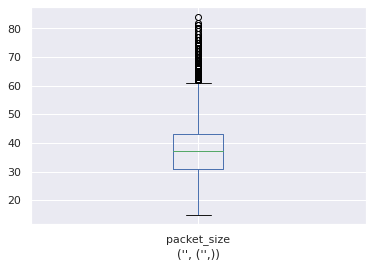

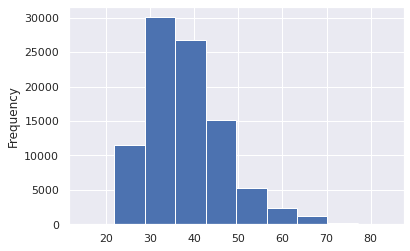

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
513833,15,"(51, 15, 31)",DR8-FJRB0-SX222.CSV,FJRB0,You always come up with pathological examples.,,"(,)","(, (,))"
155034,17,"(35, 17, 51)",DR3-MAKR0-SA2.CSV,MAKR0,Don't ask me to carry an oily rag like that.,,"(,)","(, (,))"
78620,18,"(64, 18, 40)",DR2-MDLC2-SA2.CSV,MDLC2,Don't ask me to carry an oily rag like that.,,"(,)","(, (,))"
402451,19,"(38, 19, 26)",DR6-MCAE0-SX277.CSV,MCAE0,The rose corsage smelled sweet.,,"(,)","(, (,))"
416735,19,"(33, 19, 27)",DR6-MSDS0-SX267.CSV,MSDS0,"Draw every outer line first, then fill in the ...",,"(,)","(, (,))"
29858,19,"(23, 19, 24)",DR1-MPGR0-SI1410.CSV,MPGR0,We will achieve a more vivid sense of what it ...,,"(,)","(, (,))"
143340,19,"(30, 19, 44)",DR3-FLTM0-SX170.CSV,FLTM0,The Mayan neoclassic scholar disappeared while...,,"(,)","(, (,))"
517434,20,"(31, 20, 23)",DR8-FNKL0-SX442.CSV,FNKL0,Suburban housewives often suffer from the gab ...,,"(,)","(, (,))"
528955,20,"(0, 20, 28)",DR8-MMWS0-SX78.CSV,MMWS0,Doctors prescribe drugs too freely.,,"(,)","(, (,))"
39754,20,"(51, 20, 28)",DR1-MTPF0-SX245.CSV,MTPF0,Does Hindu ideology honor cows?,,"(,)","(, (,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
101027,84,"(55, 84, 65)",DR2-MMAA0-SX125.CSV,MMAA0,Westchester is a county in New York.,,"(,)","(, (,))"
439856,82,"(62, 82, 68)",DR7-FPAB1-SX121.CSV,FPAB1,Trespassing is forbidden and subject to penalty.,,"(,)","(, (,))"
28520,81,"(69, 81, 65)",DR1-MMRP0-SX54.CSV,MMRP0,The eastern coast is a place for pure pleasure...,,"(,)","(, (,))"
22884,81,"(75, 81, 67)",DR1-MJWT0-SI1381.CSV,MJWT0,"But briefly, the topping configuration must be...",,"(,)","(, (,))"
135985,80,"(62, 80, 45)",DR3-FGCS0-SA1.CSV,FGCS0,She had your dark suit in greasy wash water al...,,"(,)","(, (,))"
357615,80,"(69, 80, 62)",DR5-MPMB0-SI2131.CSV,MPMB0,You had to be stupid or crazy or immortal.,,"(,)","(, (,))"
381277,80,"(74, 80, 63)",DR5-MWSH0-SI796.CSV,MWSH0,"The filtered air benefits allergies, asthma, s...",,"(,)","(, (,))"
83415,79,"(51, 79, 67)",DR2-MDWD0-SX90.CSV,MDWD0,The Thinker is a famous sculpture.,,"(,)","(, (,))"
439647,78,"(74, 78, 50)",DR7-FPAB1-SI841.CSV,FPAB1,Every single problem touched on thus far is re...,,"(,)","(, (,))"
98615,78,"(71, 78, 69)",DR2-MKDT0-SI814.CSV,MKDT0,Fall slowly forward onto the hands and let the...,,"(,)","(, (,))"




Unique trigram values: 3945 	Unique packet size values: 61
Current label:		 ('æ', ('that',))
Total values: 4371
Lower outsiders: 37
Upper outsiders: 10



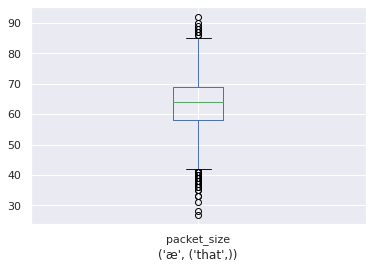

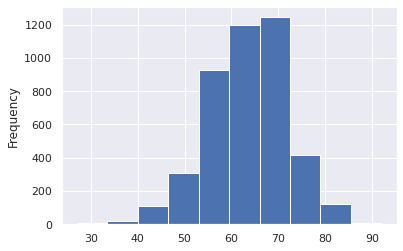

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
17230,27,"(63, 27, 45)",DR1-MDAC0-SA2.CSV,MDAC0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
298086,28,"(46, 28, 40)",DR5-FCDR1-SA2.CSV,FCDR1,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
255081,31,"(62, 31, 39)",DR4-MJLB0-SA2.CSV,MJLB0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
450323,33,"(52, 33, 44)",DR7-MBML0-SA2.CSV,MBML0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
270943,33,"(71, 33, 39)",DR4-MLSH0-SA2.CSV,MLSH0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
408295,35,"(51, 35, 36)",DR6-MKES0-SA2.CSV,MKES0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
257315,35,"(53, 35, 57)",DR4-MJMM0-SA2.CSV,MJMM0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
408296,36,"(35, 36, 67)",DR6-MKES0-SA2.CSV,MKES0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
265730,36,"(52, 36, 48)",DR4-MLBC0-SA2.CSV,MLBC0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
148960,36,"(56, 36, 49)",DR3-FSJW0-SA2.CSV,FSJW0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
489634,92,"(73, 92, 68)",DR7-MREM0-SA2.CSV,MREM0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
137272,90,"(78, 90, 66)",DR3-FGRW0-SI1152.CSV,FGRW0,You could also say that in these pamphlets is ...,æ,"(that,)","(æ, (that,))"
256144,89,"(76, 89, 84)",DR4-MJLS0-SA2.CSV,MJLS0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
22659,88,"(67, 88, 76)",DR1-MJWT0-SA2.CSV,MJWT0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
115099,88,"(63, 88, 70)",DR2-MRJM0-SA2.CSV,MRJM0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
33783,87,"(77, 87, 72)",DR1-MRCG0-SX348.CSV,MRCG0,I'll have a scoop of that exotic purple and tu...,æ,"(that,)","(æ, (that,))"
218877,87,"(66, 87, 73)",DR4-FCAG0-SA2.CSV,FCAG0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
251611,87,"(64, 87, 70)",DR4-MJDC0-SA2.CSV,MJDC0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
416027,86,"(70, 86, 70)",DR6-MSDS0-SA2.CSV,MSDS0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"
514507,86,"(80, 86, 71)",DR8-FKLH0-SA2.CSV,FKLH0,Don't ask me to carry an oily rag like that.,æ,"(that,)","(æ, (that,))"




Unique trigram values: 3242 	Unique packet size values: 57
Current label:		 ('æ', ('rag',))
Total values: 3544
Lower outsiders: 18
Upper outsiders: 2



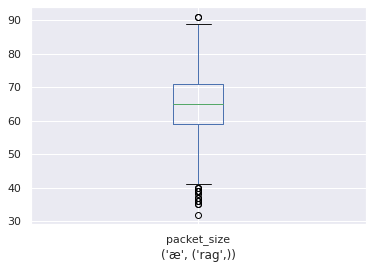

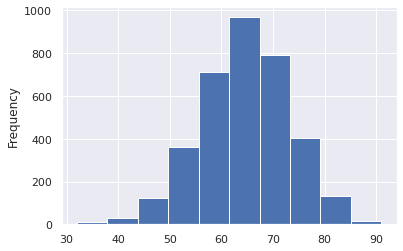

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
307967,32,"(37, 32, 53)",DR5-FJXM0-SA2.CSV,FJXM0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
320846,35,"(52, 35, 36)",DR5-FSJG0-SA2.CSV,FSJG0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
468246,35,"(50, 35, 51)",DR7-MGAK0-SA2.CSV,MGAK0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
307965,36,"(42, 36, 37)",DR5-FJXM0-SA2.CSV,FJXM0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
320847,36,"(35, 36, 42)",DR5-FSJG0-SA2.CSV,FSJG0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
227942,36,"(39, 36, 49)",DR4-FLKM0-SA2.CSV,FLKM0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
265711,37,"(50, 37, 43)",DR4-MLBC0-SA2.CSV,MLBC0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
307966,37,"(36, 37, 32)",DR5-FJXM0-SA2.CSV,FJXM0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
10832,37,"(46, 37, 55)",DR1-FSJK1-SA2.CSV,FSJK1,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
217637,38,"(49, 38, 39)",DR4-FBMJ0-SA2.CSV,FBMJ0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
175310,91,"(73, 91, 85)",DR3-MGAF0-SA2.CSV,MGAF0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
176249,91,"(79, 91, 77)",DR3-MHJB0-SA2.CSV,MHJB0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
172944,89,"(86, 89, 70)",DR3-MDWM0-SA2.CSV,MDWM0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
513342,89,"(84, 89, 73)",DR8-FJRB0-SA2.CSV,FJRB0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
445105,88,"(80, 88, 77)",DR7-MADD0-SA2.CSV,MADD0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
341741,88,"(81, 88, 75)",DR5-MHIT0-SA2.CSV,MHIT0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
87151,88,"(85, 88, 81)",DR2-MJBG0-SA2.CSV,MJBG0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
31658,88,"(77, 88, 69)",DR1-MRAI0-SA2.CSV,MRAI0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
198617,88,"(90, 88, 81)",DR3-MREH1-SA2.CSV,MREH1,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"
178353,87,"(77, 87, 75)",DR3-MILB0-SA2.CSV,MILB0,Don't ask me to carry an oily rag like that.,æ,"(rag,)","(æ, (rag,))"




Unique trigram values: 2163 	Unique packet size values: 31
Current label:		 ('s', ('suit',))
Total values: 2735
Lower outsiders: 2
Upper outsiders: 7



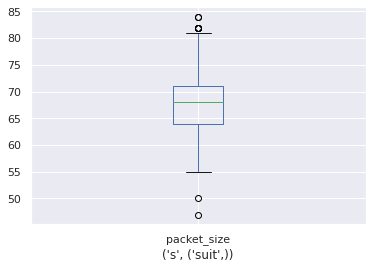

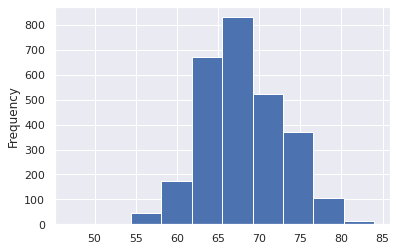

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
16023,47,"(58, 47, 64)",DR1-MCPM0-SA1.CSV,MCPM0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
70781,50,"(63, 50, 68)",DR2-MBJV0-SA1.CSV,MBJV0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
393624,55,"(68, 55, 67)",DR6-FSBK0-SA1.CSV,FSBK0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
229103,55,"(63, 55, 62)",DR4-FPAF0-SA1.CSV,FPAF0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
382062,55,"(64, 55, 60)",DR6-FAPB0-SA1.CSV,FAPB0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
6745,55,"(60, 55, 79)",DR1-FKFB0-SA1.CSV,FKFB0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
130286,55,"(67, 55, 65)",DR3-FCKE0-SA1.CSV,FCKE0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
490562,55,"(67, 55, 63)",DR7-MRLJ1-SA1.CSV,MRLJ1,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
418446,56,"(63, 56, 65)",DR6-MSMR0-SA1.CSV,MSMR0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
488282,56,"(69, 56, 64)",DR7-MPFU0-SA1.CSV,MPFU0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
99375,84,"(69, 84, 79)",DR2-MKJO0-SA1.CSV,MKJO0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
31487,84,"(73, 84, 70)",DR1-MRAI0-SA1.CSV,MRAI0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
258173,82,"(71, 82, 71)",DR4-MJPM1-SA1.CSV,MJPM1,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
60623,82,"(63, 82, 64)",DR2-FMKF0-SA1.CSV,FMKF0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
474991,82,"(62, 82, 72)",DR7-MJAI0-SA1.CSV,MJAI0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
498573,82,"(59, 82, 71)",DR7-MTER0-SA1.CSV,MTER0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
425749,82,"(69, 82, 68)",DR7-FCRZ0-SA1.CSV,FCRZ0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
384817,81,"(69, 81, 70)",DR6-FHXS0-SA1.CSV,FHXS0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
237252,81,"(80, 81, 74)",DR4-MCDR0-SA1.CSV,MCDR0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"
111262,81,"(75, 81, 75)",DR2-MRGS0-SA1.CSV,MRGS0,She had your dark suit in greasy wash water al...,s,"(suit,)","(s, (suit,))"




Unique trigram values: 2703 	Unique packet size values: 53
Current label:		 ('u', ('suit',))
Total values: 2861
Lower outsiders: 2
Upper outsiders: 7



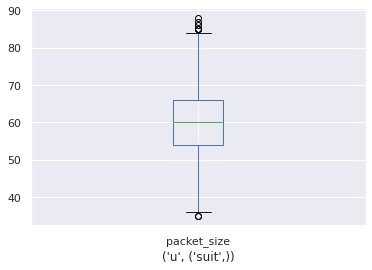

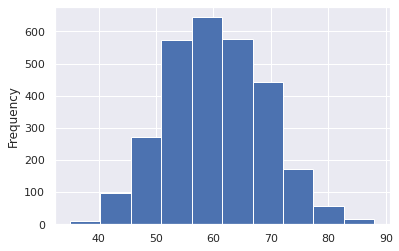

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
393631,35,"(48, 35, 46)",DR6-FSBK0-SA1.CSV,FSBK0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
65181,35,"(43, 35, 54)",DR2-FSCN0-SA1.CSV,FSCN0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
471560,36,"(50, 36, 55)",DR7-MGSL0-SA1.CSV,MGSL0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
470518,37,"(48, 37, 61)",DR7-MGAW0-SA1.CSV,MGAW0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
324531,39,"(50, 39, 49)",DR5-FSMS1-SA1.CSV,FSMS1,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
355304,39,"(54, 39, 43)",DR5-MMWB0-SA1.CSV,MMWB0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
245459,40,"(61, 40, 47)",DR4-MGAG0-SA1.CSV,MGAG0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
430901,40,"(48, 40, 44)",DR7-FJSK0-SA1.CSV,FJSK0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
323313,40,"(47, 40, 49)",DR5-FSMM0-SA1.CSV,FSMM0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
65178,40,"(44, 40, 48)",DR2-FSCN0-SA1.CSV,FSCN0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
493676,88,"(67, 88, 64)",DR7-MRPC1-SA1.CSV,MRPC1,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
467064,87,"(73, 87, 64)",DR7-MFXV0-SA1.CSV,MFXV0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
41332,86,"(70, 86, 61)",DR1-MWAD0-SA1.CSV,MWAD0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
405080,85,"(69, 85, 69)",DR6-MEJL0-SA1.CSV,MEJL0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
120487,85,"(75, 85, 78)",DR2-MRMS0-SA1.CSV,MRMS0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
302423,85,"(55, 85, 59)",DR5-FEAR0-SA1.CSV,FEAR0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
63994,85,"(65, 85, 62)",DR2-FRLL0-SA1.CSV,FRLL0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
432038,84,"(65, 84, 51)",DR7-FKDE0-SA1.CSV,FKDE0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
355298,84,"(71, 84, 60)",DR5-MMWB0-SA1.CSV,MMWB0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"
163128,84,"(62, 84, 58)",DR3-MDDC0-SA1.CSV,MDDC0,She had your dark suit in greasy wash water al...,u,"(suit,)","(u, (suit,))"


In [55]:
#change this array for analysis on more values
interesting_bilabels = [((""), ("",)), (("æ"), ("that",)), (("æ"), ("rag",)), (("s"), ("suit",)), (("u"), ("suit",))]

for bila in interesting_bilabels:
    graph_data = bilabel.loc[bilabel.phoneme_word == bila]
    print("Unique trigram values:", len(pd.unique(graph_data['packet_surrounding'])), "\tUnique packet size values:", len(pd.unique(graph_data['packet_size'])))
    #graph_data = graph_data.copy() #.loc was somehow acting up and not copying properly
    get_distribution_info(graph_data, bila)
    print('\n')

Still the values for the phonemes are kinda "all over the place" but not that much as with analysis for only words / phonemes. But the all these analyses have a common downfall, majority of the samples overlap with their "packet_size". 

So let's try to look at analysis based on triphones.

In [49]:
trigram_freq = bilabel[['packet_surrounding', 'phoneme_word']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  phoneme_word     
(30, 29, 29)        (, (,))              56
(38, 37, 0)         (, (,))              54
(30, 31, 31)        (, (,))              53
(0, 29, 29)         (, (,))              52
(0, 30, 28)         (, (,))              52
                                         ..
(68, 59, 67)        (s, (suit,))          1
                    (s, (zoologist,))     1
                    (t, (into,))          1
                    (u, (suit,))          1
(0, 20, 28)         (, (,))               1
Length: 459274, dtype: int64

In [50]:
print("Sanity sum check:", sum(trigram_freq.values))
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

Sanity sum check: 533705


array([[     1, 441527],
       [     2,   8901],
       [     3,   2281],
       [     4,   1289],
       [     5,    807],
       [     6,    650],
       [     7,    507],
       [     8,    401],
       [     9,    356],
       [    10,    320],
       [    11,    255],
       [    12,    229],
       [    13,    192],
       [    14,    170],
       [    15,    166],
       [    16,    139],
       [    17,    124],
       [    18,    116],
       [    19,    117],
       [    20,     79],
       [    21,     68],
       [    22,     62],
       [    23,     65],
       [    24,     52],
       [    25,     40],
       [    26,     51],
       [    27,     47],
       [    28,     31],
       [    29,     36],
       [    30,     27],
       [    31,     20],
       [    32,     19],
       [    33,     15],
       [    34,     12],
       [    35,     12],
       [    36,     15],
       [    37,     13],
       [    38,     11],
       [    39,      4],
       [    40,      9],


Well we've achieved a huge granurality, which isn't a good thing. This says to me that with packet sizes that there will be inherently some lost information in translation. So the problem with this granurality is that we will hardly be able to generalise our model (as it seems, that multiple trigrams of packets sizes encode different `(phonemes, words)`

In [51]:
def analyse_phoneme_trigrams(trigram):
    concrete_phoneme = bilabel[bilabel.packet_surrounding == trigram]
    print("Unique values:", len(pd.unique(concrete_phoneme['phoneme_word'])))
    temp = concrete_phoneme.groupby(by=['phoneme_word', 'packet_surrounding'])['phonemes'].count()
    print("Total values: ",sum(temp.values))
    display(temp.sort_values(ascending=False))

    temp1 = concrete_phoneme.groupby(by=['phoneme_word', 'packet_surrounding', 'speaker'])['phonemes'].count()
    print("\nTotal values: ",sum(temp1.values))
    display(temp1.sort_values(ascending=False))
    print("\n")
    
interesting_trigrams = [(68, 68, 64), (65, 63, 63), (67, 65, 66), (66, 67, 65)]
for trigram in interesting_trigrams:
    analyse_phoneme_trigrams(trigram)

Unique values: 74
Total values:  83


phoneme_word      packet_surrounding
(ʃ, (she,))       (68, 68, 64)          4
(ʃ, (wash,))      (68, 68, 64)          3
(æ, (that,))      (68, 68, 64)          3
(s, (ask,))       (68, 68, 64)          2
(u, (suit,))      (68, 68, 64)          2
                                       ..
(z, (bells,))     (68, 68, 64)          1
(u, (units,))     (68, 68, 64)          1
(tʃ, (check,))    (68, 68, 64)          1
(t, (activity,))  (68, 68, 64)          1
(, (,))           (68, 68, 64)          1
Name: phonemes, Length: 74, dtype: int64

/home/xkadlec6/.local/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:1231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)



Total values:  83


phoneme_word        packet_surrounding  speaker
(s, (juice,))       (68, 68, 64)        MMSM0      1
(s, (dense,))       (68, 68, 64)        FDNC0      1
(ɹ, (guarantees,))  (68, 68, 64)        FPJF0      1
(ʃ, (she,))         (68, 68, 64)        FSBK0      1
(z, (was,))         (68, 68, 64)        FLHD0      1
                                                  ..
(ɔ, (all,))         (68, 68, 64)        MAPV0      0
                                        MARC0      0
                                        MARW0      0
                                        MBAR0      0
(, (,))             (68, 68, 64)        FAEM0      0
Name: phonemes, Length: 34188, dtype: int64



Unique values: 83
Total values:  87


phoneme_word       packet_surrounding
(θ, (with,))       (65, 63, 63)          2
(ɹ, (greasy,))     (65, 63, 63)          2
(æ, (had,))        (65, 63, 63)          2
(, (,))            (65, 63, 63)          2
(ʃ, (shellfish,))  (65, 63, 63)          1
                                        ..
(ɔ, (ball,))       (65, 63, 63)          1
(ɔ, (corsage,))    (65, 63, 63)          1
(ɔ, (sought,))     (65, 63, 63)          1
(ɔɪ, (oily,))      (65, 63, 63)          1
(t, (tube,))       (65, 63, 63)          1
Name: phonemes, Length: 83, dtype: int64


Total values:  87


phoneme_word    packet_surrounding  speaker
(s, (face,))    (65, 63, 63)        FKFB0      1
(ɔɪ, (oily,))   (65, 63, 63)        MRCG0      1
(ə, (a,))       (65, 63, 63)        MRDM0      1
(ɪ, (his,))     (65, 63, 63)        MSMS0      1
(s, (small,))   (65, 63, 63)        MTJU0      1
                                              ..
(ɔ, (sought,))  (65, 63, 63)        MAEB0      0
                                    MADD0      0
                                    MADC0      0
                                    MABC0      0
(, (,))         (65, 63, 63)        FAEM0      0
Name: phonemes, Length: 38346, dtype: int64



Unique values: 72
Total values:  76


phoneme_word       packet_surrounding
(s, (suit,))       (67, 65, 66)          3
(s, (so,))         (67, 65, 66)          2
(æ, (that,))       (67, 65, 66)          2
(θ, (that,))       (67, 65, 66)          1
(s, (effects,))    (67, 65, 66)          1
                                        ..
(t, (to,))         (67, 65, 66)          1
(s, (us,))         (67, 65, 66)          1
(s, (unless,))     (67, 65, 66)          1
(s, (spherical,))  (67, 65, 66)          1
(aɪ, (cry,))       (67, 65, 66)          1
Name: phonemes, Length: 72, dtype: int64


Total values:  76


phoneme_word      packet_surrounding  speaker
(s, (books,))     (67, 65, 66)        MHMR0      1
(f, (flurries,))  (67, 65, 66)        MDPS0      1
(s, (service,))   (67, 65, 66)        FNKL0      1
(l, (oily,))      (67, 65, 66)        MJWG0      1
(ɔ, (long,))      (67, 65, 66)        MJJM0      1
                                                ..
(æ, (that,))      (67, 65, 66)        MWGR0      0
                                      MWRE0      0
                                      MWRP0      0
                                      MWSB0      0
(aɪ, (cry,))      (67, 65, 66)        FAEM0      0
Name: phonemes, Length: 33264, dtype: int64



Unique values: 73
Total values:  79


phoneme_word       packet_surrounding
(ʃ, (she,))        (66, 67, 65)          3
(oʊ, (don't,))     (66, 67, 65)          2
(ɔ, (all,))        (66, 67, 65)          2
(ɚ, (water,))      (66, 67, 65)          2
(u, (suit,))       (66, 67, 65)          2
                                        ..
(æ, (ambitions,))  (66, 67, 65)          1
(z, (hands,))      (66, 67, 65)          1
(z, (allergies,))  (66, 67, 65)          1
(ʌ, (hyena,))      (66, 67, 65)          1
(, (,))            (66, 67, 65)          1
Name: phonemes, Length: 73, dtype: int64


Total values:  79


phoneme_word    packet_surrounding  speaker
(ɔ, (on,))      (66, 67, 65)        MHXL0      1
(t, (two,))     (66, 67, 65)        FEAR0      1
(s, (suit,))    (66, 67, 65)        MDSJ0      1
(ʌ, (sudden,))  (66, 67, 65)        FEXM0      1
(z, (hands,))   (66, 67, 65)        MKDT0      1
                                              ..
(ɔ, (all,))     (66, 67, 65)        MKLR0      0
                                    MKLS0      0
                                    MKLS1      0
                                    MKLW0      0
(, (,))         (66, 67, 65)        FAEM0      0
Name: phonemes, Length: 33726, dtype: int64

And it is as we feared, the trigram of packet sizes aren't that well defined and don't provide us with definitive answer to clasification and recognition.